In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
import scipy.stats as stats
from scipy.special import erf

In [132]:
def gsmooth(x_array, y_array, var_y, vexp = .001, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [133]:
def autosmooth(x_array, y_array, var_y):
    new_y_init = gsmooth(x_array, y_array, var_y, .001)
    SNR = np.mean(new_y_init / var_y)
    
    if SNR < 5:
        vexp_auto = .0045#.0025 #temp value, need to fine tune using SNR in excel spreadsheet
    elif 5 <= SNR < 20:
        vexp_auto = .004#.002
    elif 20 <= SNR < 40:
        vexp_auto = .003#.0015
    elif 40 <= SNR < 60:
        vexp_auto = .002#.001
    elif 60 <= SNR < 100:
        vexp_auto = .0015#.00075
    else:
        vexp_auto = .001#.0005
    
    new_y = gsmooth(x_array, y_array, var_y, vexp_auto)
    return new_y

In [246]:
def dm15_to_x1(dm15):
    return np.roots([0.01828958, - 0.13430543, 1.02585001 - dm15])[1]

# SALT Comparisons

In [225]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_m2 = flux_salt# - 3.06*salt_corr #dm15=1.61
flux_salt_p1 = flux_salt + 1.85*salt_corr #dm15=.84

In [226]:
salt_temps_m2 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_m2[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_m2[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_m2[i])
    first = False
    
salt_temps_p1 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_p1[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_p1[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_p1[i])
    first = False

In [227]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.spectrum(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    return s_template

In [228]:
m2_salt_template = make_obj_from_template(salt_temps_m2[0.][0], salt_temps_m2[0.][1])
p1_salt_template = make_obj_from_template(salt_temps_p1[0.][0], salt_temps_p1[0.][1])

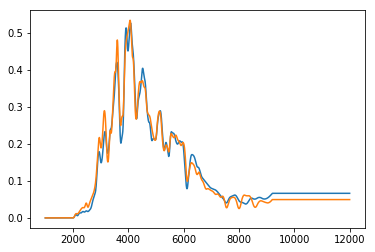

In [229]:
plt.plot(m2_salt_template.wavelength, m2_salt_template.flux)
plt.plot(p1_salt_template.wavelength, p1_salt_template.flux)
plt.show()

# dm15 = 1.61 Comparisons

In [230]:
#test_query = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -30000 and -12000)"
query = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -30000 and -12000)",
        "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -12000 and -6500)"]
composites, sn_arrays, boot_sn_arrays = query_db.main(len(query), query, boot=True, medmean=1, gini_balance = True, verbose=False, combine=True)

SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -30000 and -12000)
7 Total Spectra found
0 flagged spectra removed 7 spectra left
0 spectra of peculiar Ias removed 7 spectra left
7 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
6 total SNe
removed spectra of SNe with A_V > 2.0
Using 7 spectra of 6 SNe
Gini balancing...
Balanced after 7 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -12000 and -6500)
39 Total Spectra found
1 flagged spectra removed 38 spectra left
0 spectra of peculiar Ias removed

1.008699444160765
0.9956917954209077


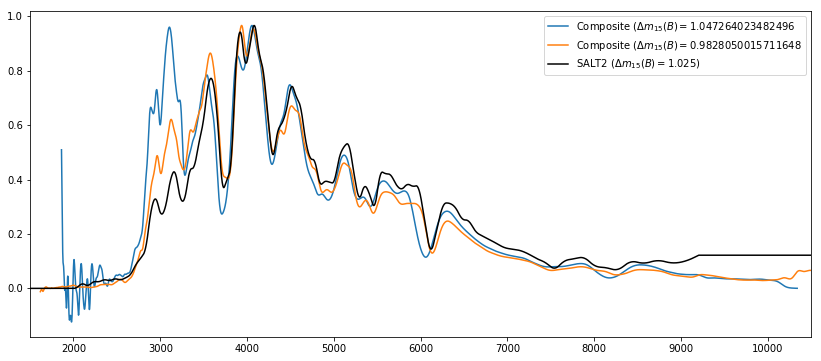

In [159]:
plt.figure(figsize=(14,6))
plt.xlim(1500, 10500)

for object in composites:
    x1,x2 = object.x1, object.x2
    
    flux = autosmooth(object.wavelength[x1:x2], object.flux[x1:x2], 1 / object.ivar[x1:x2]**(1/2))
    ######### determine scaling ##########
    '''SALT_maxflux = np.max(m2_salt_template.flux)
    SALT_maxflux_index = np.argmax(m2_salt_template.flux)
    SALT_wavelength = m2_salt_template.wavelength[SALT_maxflux_index]

    composite_index = np.where(object.wavelength[x1:x2] == SALT_wavelength)[0]
    composite_maxflux = flux[composite_index]

    print SALT_maxflux, composite_maxflux[0]
    
    scale = SALT_maxflux / composite_maxflux
    print scale'''
    scale = max(flux) / max(m2_salt_template.flux)
    print scale
    
    dm15_avg = np.mean(object.dm15_array[object.x1:object.x2])
    
    plt.plot(object.wavelength[x1:x2], flux / scale , label = 'Composite ($\Delta m_{15} (B) = ' + str(dm15_avg) + "$")
    #######################################

plt.plot(m2_salt_template.wavelength, m2_salt_template.flux, label = 'SALT2 ($\Delta m_{15} (B) = 1.025$)', color='black')

plt.legend()

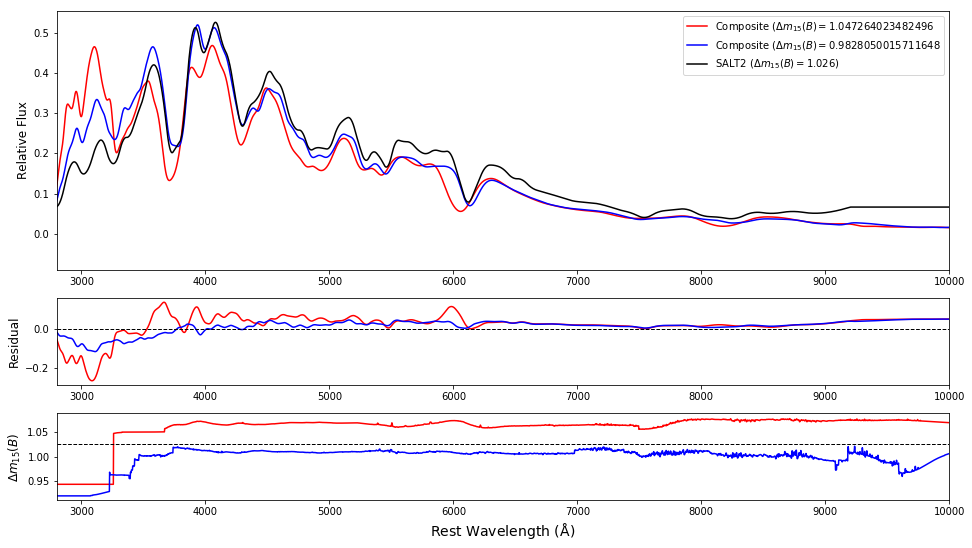

In [231]:
plot_objects = [composites[0], composites[1], m2_salt_template]
plot_objects, scales = composite.optimize_scales(plot_objects, plot_objects[-1], True)

fig = plt.figure(1, figsize=(16,9))
#plt.xlim(1500, 10500)
gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1]) # two grids, top is 3 times taller

ax1 = fig.add_subplot(gs[0])
ax1.set_xlim(2800, 10000)
ax1.set_ylabel("Relative Flux", fontsize=12)

ax2 = fig.add_subplot(gs[1])
ax2.set_xlim(2800, 10000)
ax2.set_ylabel("Residual", fontsize=12)

ax3 = fig.add_subplot(gs[2])
ax3.set_xlim(2800, 10000)
ax3.set_ylabel("$\Delta m_{15} (B)$", fontsize=12)
ax3.set_xlabel("Rest Wavelength ($\mathrm{\AA}$)", fontsize=14)

colors = ["red", "blue"]
i=0
for object in plot_objects[:-1]:
    x1, x2 = object.x1, object.x2
    dm15_avg = np.mean(object.dm15_array[object.x1:object.x2])
    flux = autosmooth(object.wavelength[x1:x2], object.flux[x1:x2], 1 / object.ivar[x1:x2]**(1/2))
    
    ax1.plot(object.wavelength[x1:x2], flux , label = 'Composite ($\Delta m_{15} (B) = ' + str(dm15_avg) + "$", color=colors[i])
    
    #residuals = flux-plot_objects[-1].flux
    #residuals
    ax2.plot(object.wavelength[x1:x2], plot_objects[-1].flux[x1:x2] - flux, color=colors[i])
    
    #dm15
    ax3.plot(object.wavelength[x1:x2], object.dm15_array[x1:x2], color=colors[i])
    i+=1
    
ax1.plot(plot_objects[-1].wavelength, plot_objects[-1].flux, label = 'SALT2 ($\Delta m_{15} (B) = 1.026$)', color='black')
ax1.legend()

ax2.axhline(0, color='black', linestyle="--", linewidth=1)

ax3.axhline(1.026,color='black', linestyle="--", linewidth=1)

# SALT Comparisons at different dm15

In [294]:
def SALT_compare(dm15, boot=False):
    '''
    Creates high and low velocity composite spectra split at -12000 km/s to compare to SALT template of similar dm15
    
    INPUTS:
    
        dm15: B band dm15 for SALT template. Composite spectra will be created from spectra with dm15 +- .1

        boot: On/off creation on composite boot arrays
    
    OUTPUTS:
    
        highv_chisqr: chi square of high velocity composite relative to SALT divided by number of points
        
        lowv_chisqr: chi square of high velocity composite relative to SALT divided by number of points
    '''
    
    ################### CREATING SALT TEMPLATE #####################
    x1 = dm15_to_x1(dm15)
    template_flux = flux_salt + x1*salt_corr
    
    salt_temps = {}
    phase_list = []
    first = True
    for i, phase in enumerate(phase_s):
        if phase not in phase_list:
            phase_list.append(phase)
            if not first:
                salt_temps[float(phase_s[i-1])] = [temp_wave, temp_flux]
            temp_wave = [wavelength_salt[i]]
            temp_flux = [template_flux[i]]
        else:
            temp_wave.append(wavelength_salt[i])
            temp_flux.append(template_flux[i])
        first = False
    
    salt_template = make_obj_from_template(salt_temps[0.][0], salt_temps[0.][1])
    
    #plt.plot(salt_template.wavelength, salt_template.flux)
    ##################################################################
    
    
    
    #################### CREATING COMPOSITE SPECTRA ##################
    dm15_lower = str(dm15-.1)
    dm15_upper = str(dm15+.1)
    
    query = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= " + dm15_lower +" and dm15_source < " + dm15_upper +") or (dm15_from_fits >= " + dm15_lower +" and dm15_from_fits < " + dm15_upper +")) and (si_v0 between -30000 and -12000)",
            "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= " + dm15_lower +" and dm15_source < " + dm15_upper +") or (dm15_from_fits >= " + dm15_lower +" and dm15_from_fits < " + dm15_upper +")) and (si_v0 between -12000 and -6500)"]
    
    print query[0]
    
    composites, sn_arrays, boot_sn_arrays = query_db.main(len(query), query, boot=boot, medmean=1, gini_balance = True, verbose=False, combine=True)
    ###################################################################
    
    
    
    ################################ PLOTTING #####################
    plot_objects = [composites[0], composites[1], salt_template]
    plot_objects, scales = composite.optimize_scales(plot_objects, plot_objects[-1], True)
    
    fig = plt.figure(1, figsize=(16,9))
    #plt.xlim(1500, 10500)
    gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1]) # two grids, top is 3 times taller

    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlim(2800, 10000)
    ax1.set_ylabel("Relative Flux", fontsize=12)

    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(2800, 10000)
    ax2.set_ylabel("Residual", fontsize=12)

    ax3 = fig.add_subplot(gs[2])
    ax3.set_xlim(2800, 10000)
    ax3.set_ylabel("$\Delta m_{15} (B)$", fontsize=12)
    ax3.set_xlabel("Rest Wavelength ($\mathrm{\AA}$)", fontsize=14)

    colors = ["red", "blue"]
    i=0
    
    chi_sqr_array = []
    
    for object in plot_objects[:-1]:
        x1, x2 = object.x1, object.x2
        dm15_avg = np.mean(object.dm15_array[object.x1:object.x2])
        flux = autosmooth(object.wavelength[x1:x2], object.flux[x1:x2], 1 / object.ivar[x1:x2]**(1/2))

        ax1.plot(object.wavelength[x1:x2], flux , label = 'Composite ($\Delta m_{15} (B) = ' + str(dm15_avg) + "$", color=colors[i])

        #residuals = flux-plot_objects[-1].flux
        #residuals
        ax2.plot(object.wavelength[x1:x2], plot_objects[-1].flux[x1:x2] - flux, color=colors[i])
        
        chi_sqr = stats.chisquare(flux, plot_objects[-1].flux[x1:x2])[0] / len(flux)
        chi_sqr_array.append(chi_sqr)

        #dm15
        ax3.plot(object.wavelength[x1:x2], object.dm15_array[x1:x2], color=colors[i])
        i+=1

    ax1.plot(plot_objects[-1].wavelength, plot_objects[-1].flux, label = 'SALT2 ($\Delta m_{15} (B) = '+str(dm15)+'$)', color='black')
    ax1.legend()

    ax2.axhline(0, color='black', linestyle="--", linewidth=1)

    ax3.axhline(dm15,color='black', linestyle="--", linewidth=1)
    
    plt.show()
    ######################################################################
    
    
    
    ############################## Return Chi-Squares #####################
    highv_chisqr, lowv_chisqr = chi_sqr_array[0], chi_sqr_array[1]
    
    return highv_chisqr, lowv_chisqr

SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.0 and dm15_source < 1.2) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.2)) and (si_v0 between -30000 and -12000)
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.0 and dm15_source < 1.2) or (dm15_from_fits >= 1.0 and dm15_from_fits < 1.2)) and (si_v0 between -30000 and -12000)
15 Total Spectra found
1 flagged spectra removed 14 spectra left
0 spectra of peculiar Ias removed 14 spectra left
14 spectra of SNe that have host reddening corrections
Arrays cleaned
14 spectra may have telluric contamination
11 total SNe
removed spectra of SNe with A_V > 2.0
Using 11 spectra of 9 SNe
Gini balancing...
Balanced after 7 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.0 and dm15_source < 1.2) or (dm15_f

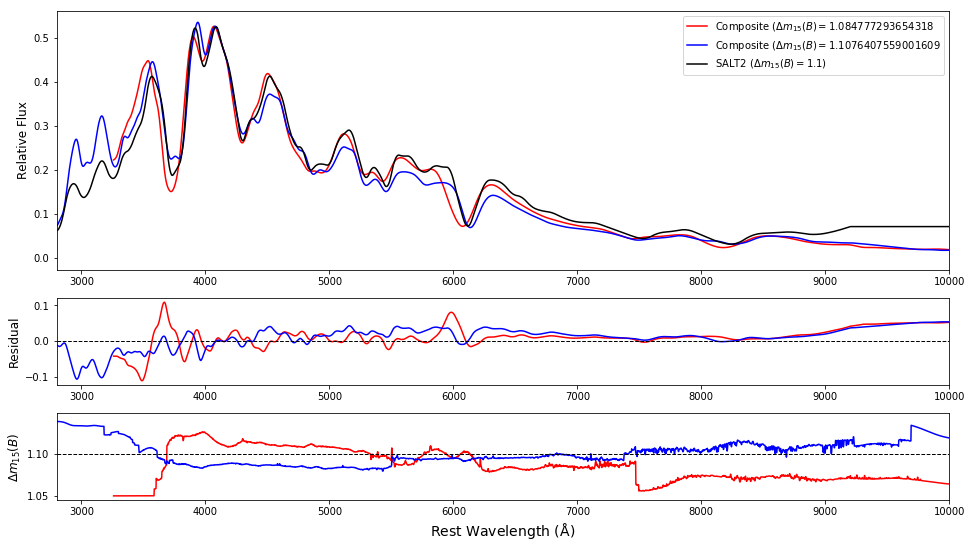

(34.64884854453639, 1.7254009673035e+18)

In [289]:
SALT_compare(1.1)

SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -30000 and -12000)
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fits >= 0.9 and dm15_from_fits < 1.1)) and (si_v0 between -30000 and -12000)
7 Total Spectra found
0 flagged spectra removed 7 spectra left
0 spectra of peculiar Ias removed 7 spectra left
7 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
6 total SNe
removed spectra of SNe with A_V > 2.0
Using 7 spectra of 6 SNe
Gini balancing...
Balanced after 7 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 0.9 and dm15_source < 1.1) or (dm15_from_fit

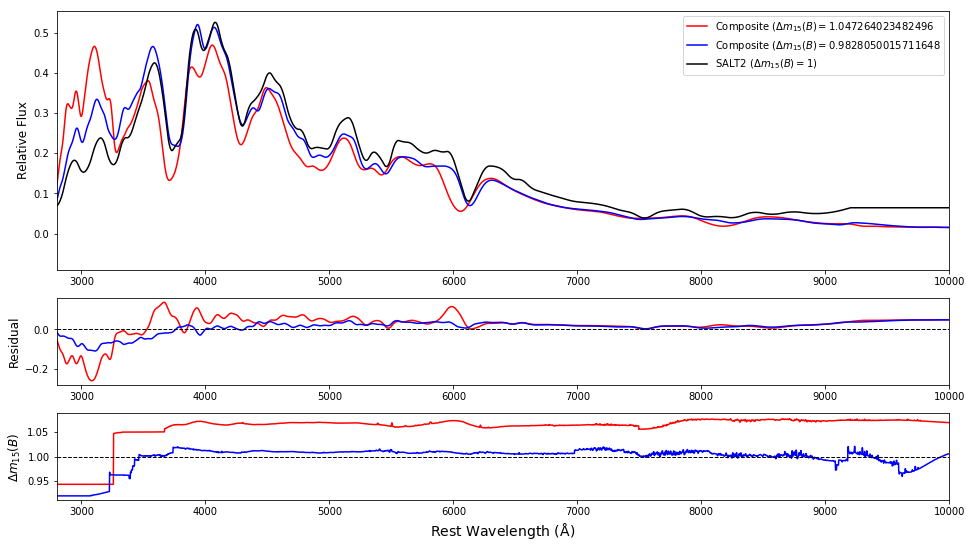

SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.1 and dm15_source < 1.3) or (dm15_from_fits >= 1.1 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.1 and dm15_source < 1.3) or (dm15_from_fits >= 1.1 and dm15_from_fits < 1.3)) and (si_v0 between -30000 and -12000)
11 Total Spectra found
1 flagged spectra removed 10 spectra left
0 spectra of peculiar Ias removed 10 spectra left
10 spectra of SNe that have host reddening corrections
Arrays cleaned
10 spectra may have telluric contamination
8 total SNe
removed spectra of SNe with A_V > 2.0
Using 7 spectra of 6 SNe
Gini balancing...
Balanced after 2 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.1 and dm15_source < 1.3) or (dm15_fro

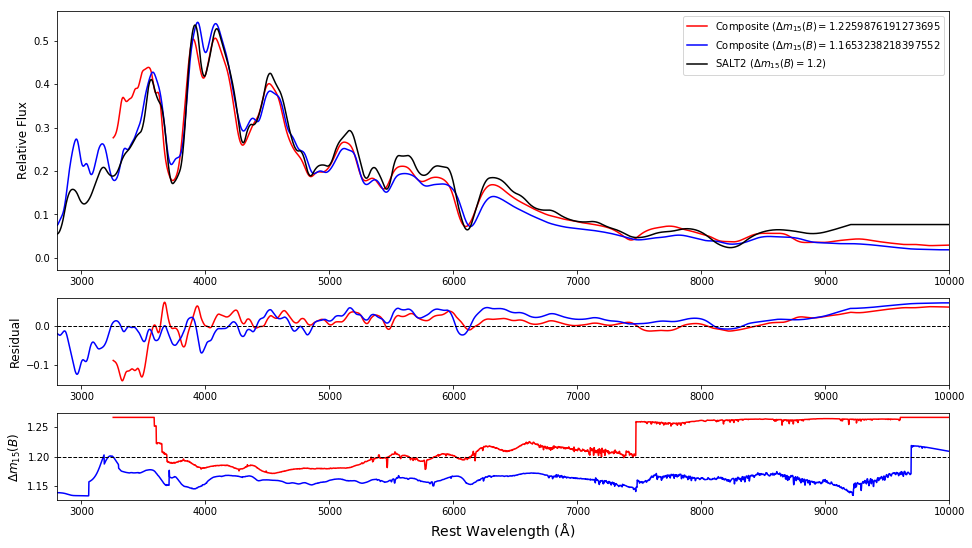

SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.3 and dm15_source < 1.5) or (dm15_from_fits >= 1.3 and dm15_from_fits < 1.5)) and (si_v0 between -30000 and -12000)
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.3 and dm15_source < 1.5) or (dm15_from_fits >= 1.3 and dm15_from_fits < 1.5)) and (si_v0 between -30000 and -12000)
7 Total Spectra found
1 flagged spectra removed 6 spectra left
0 spectra of peculiar Ias removed 6 spectra left
6 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
4 total SNe
removed spectra of SNe with A_V > 2.0
Using 6 spectra of 4 SNe
Gini balancing...
Balanced after 1 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.3 and dm15_source < 1.5) or (dm15_from_fit

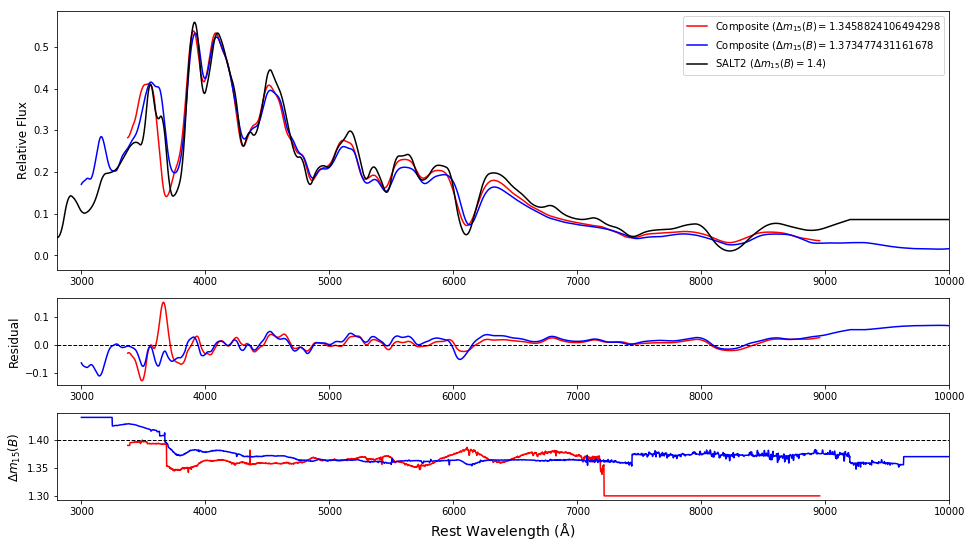

SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and (si_v0 between -30000 and -12000)
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and (si_v0 between -30000 and -12000)
2 Total Spectra found
0 flagged spectra removed 2 spectra left
0 spectra of peculiar Ias removed 2 spectra left
2 spectra of SNe that have host reddening corrections
Arrays cleaned
0 spectra may have telluric contamination
1 total SNe
removed spectra of SNe with A_V > 2.0
Using 2 spectra of 1 SNe
Gini balancing...
Balanced after 1 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase > -1 and phase < 1 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fit

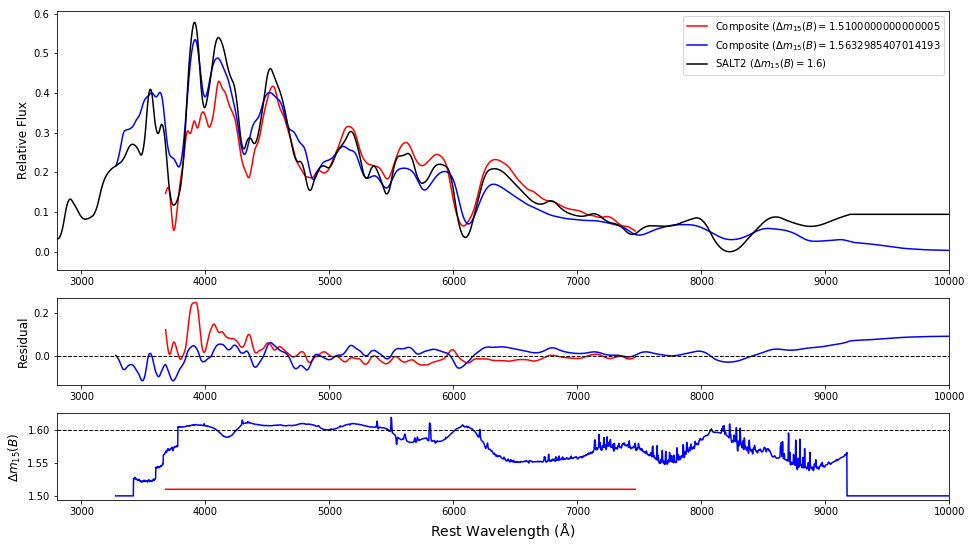

In [295]:
dm15_bins = [1, 1.2, 1.4, 1.6]
chi_sqr_values = []
for dm15 in dm15_bins:
    highv_chisqr, lowv_chisqr = SALT_compare(dm15)
    chi_sqr_values.append((highv_chisqr, lowv_chisqr))


In [296]:
print chi_sqr_values

[(1.0329074169828096e+16, 60654468941608.9), (0.007265616155835191, 1182186641835284.0), (0.004425383863888035, 0.012999390643252284), (0.007268113050855684, 0.024228559624415114)]


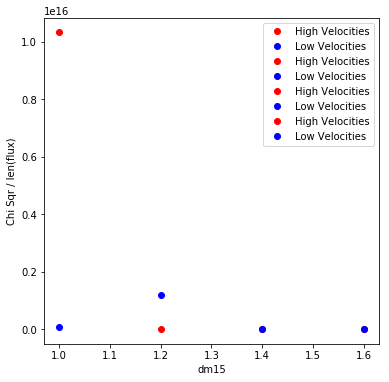

In [304]:
plt.figure(figsize=(6,6))
plt.xlabel('dm15')
plt.ylabel('Chi Sqr / len(flux)')
for n in range(len(dm15_bins)):
    plt.plot(dm15_bins[n], chi_sqr_values[n][0],'o', color='red', label='High Velocities')
    plt.plot(dm15_bins[n], chi_sqr_values[n][1],'o', color='blue', label='Low Velocities')
plt.legend()